<a href="https://colab.research.google.com/github/littlejacinthe/Machine-Learning-Programming/blob/master/Copy_of_Chapter6_Exploring_Generative_Adversarial_Networks_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary
import numpy as np #import necessary libraries

In [ ]:
transform = transforms.Compose([ #add transforms together
    transforms.ToTensor(), #transform data type to torch tensor
    transforms.Normalize((0.5, ), (0.5, )), #normalize 
])

In [ ]:
batch_size = 128 #batch size
z_dim = 100 #latent vector size

In [ ]:
database = dataset.MNIST('mnist', train = True, download = True, transform = transform) #dl the MNIST dataset train set, transfom it 
#Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = torch.utils.data.DataLoader( #load it as a DataLoader object
    #dataset.MNIST('mnist', train = True, download = True, transform = transform),
    database, 
    batch_size = batch_size,
    shuffle = True #data is reshuffled at every epoch
)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
 for i, data in enumerate(train_loader): #print the batches : image data normalized btw [-1, 1] and label tensor
     print ("batch id =" + str(i) )
     print (data[0])
     print (data[1])
      

Streaming output truncated to the last 5000 lines.
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1

In [ ]:
def weights_init(m): #initializing weights function
    classname = m.__class__.__name__ #depending on the function initialize weights differently
    if classname.find('Conv') != -1: #for convolution
        nn.init.normal_(m.weight.data, 0.0, 0.02) #initialize weights : tensor, mean, standard deviation
    elif classname.find('BatchNorm') != -1: #for batch normalization
        nn.init.normal_(m.weight.data, 1.0, 0.02) 
        nn.init.constant_(m.bias.data, 0) #fills the input tensor with the value : tensor, value to fill with

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #look for the gpu

In [ ]:
class Generator_model(nn.Module): #generator model
    def __init__(self, z_dim):
        super().__init__()
        self.fc = nn.Linear(z_dim, 256 * 7 * 7) #linear [100, 12544] to prepare input
        self.gen = nn.Sequential( #sequential model
            nn.ConvTranspose2d(256, 128, 4, 2, 1), #conv transpose input 256, ouput 128, kernel size 4, stride 2, padding 1
            nn.BatchNorm2d(128), #batch norm over a 4d input, calculates mean and standard deviation
            nn.LeakyReLU(0.01), #0.01 is the angle of the negative slope
            nn.ConvTranspose2d(128, 64, 3, 1, 1), #input 128, ouput 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 1, 4, 2, 1), #input 64, ouput 1 -> size of D's input
            nn.Tanh() #element wise function
        )
    def forward(self, input):
        x = self.fc(input) #getting the input through the linear transformation
        x = x.view(-1, 256, 7, 7) 
        return self.gen(x) #going through the sequential model

In [ ]:
generator = Generator_model(z_dim).to(device) #send model to gpu

In [ ]:
generator.apply(weights_init) #initialize weights and see the generator model

Generator_model(
  (fc): Linear(in_features=100, out_features=12544, bias=True)
  (gen): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

In [ ]:
summary(generator, (100, )) #get the summary for more details

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,266,944
   ConvTranspose2d-2          [-1, 128, 14, 14]         524,416
       BatchNorm2d-3          [-1, 128, 14, 14]             256
         LeakyReLU-4          [-1, 128, 14, 14]               0
   ConvTranspose2d-5           [-1, 64, 14, 14]          73,792
       BatchNorm2d-6           [-1, 64, 14, 14]             128
         LeakyReLU-7           [-1, 64, 14, 14]               0
   ConvTranspose2d-8            [-1, 1, 28, 28]           1,025
              Tanh-9            [-1, 1, 28, 28]               0
Total params: 1,866,561
Trainable params: 1,866,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.97
Params size (MB): 7.12
Estimated Total Size (MB): 8.09
---------------------------------------

In [ ]:
class Discriminator_model(nn.Module): #discriminator model
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential( #sequential module
            nn.Conv2d(1, 32, 3, 2, 1), #input 1, output 32, kernel size 3, stride 2, padding 1
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64, 128, 3, 2, 1), #input 64, output 128 -> size of one image
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01)
        )
        self.fc = nn.Linear(2048, 1) #linear transform
    def forward(self, input):
        x = self.disc(input) #go through the model
        return F.sigmoid(self.fc(x.view(-1, 2048))) #element wise function

In [ ]:
discriminator = Discriminator_model().to(device) #send model to gpu

In [ ]:
discriminator.apply(weights_init) #weight initialization, see the model

Discriminator_model(
  (disc): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [ ]:
summary(discriminator, (1, 28, 28)) #summary for more details

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
         LeakyReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
       BatchNorm2d-4             [-1, 64, 7, 7]             128
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 4, 4]          73,856
       BatchNorm2d-7            [-1, 128, 4, 4]             256
         LeakyReLU-8            [-1, 128, 4, 4]               0
            Linear-9                    [-1, 1]           2,049
Total params: 95,105
Trainable params: 95,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.36
Estimated Total Size (MB): 0.58
---------------------------------------------

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
criterion = nn.BCELoss() #loss function : criterion between the target and the ouput. Binary Cross Entropy

In [ ]:
# create a batch (whose size 64) of fixed noise vectors (z_dim=100)
fixed_noise = torch.randn(64, z_dim, device=device) #make a batch of size 64, 100 of random numbers for the latent vector, on gpu

In [ ]:
doptimizer = optim.Adam(discriminator.parameters()) #Stochastic optimization of the models' params
goptimizer = optim.Adam(generator.parameters())

In [ ]:
real_label, fake_label = 1, 0 #labels for real and fake data

In [ ]:
image_list = []
g_losses = []
d_losses = []
iterations = 0
num_epochs = 50

In [ ]:
for epoch in range(num_epochs): #iterating through data given the number of epochs, for each epochs do the following :
    print(f'Epoch : | {epoch+1:03} / {num_epochs:03} |') #print the progress
    for i, data in enumerate(train_loader): #for each batch in the data loader, iterate
        
        discriminator.zero_grad() #set gradients of all params to 0
        
        real_images = data[0].to(device) # real_images: size = (128,1,28,28) -> as we iterate we're gonna go batch per batch, on gpu
      
        size = real_images.size(0) # size = 128 = batch size       
        label = torch.full((size,), real_label, device=device)  # real_label =1 all labels are set to real   
        d_output = discriminator(real_images).view(-1) #Goes through the discriminator & returns a new tensor with the same data as the self tensor but of a different shape, here -1
        derror_real = criterion(d_output, label) #calculate the errors given the output and the label      

        derror_real.backward() #compute the sum of gradients
        
        noise = torch.randn(size, z_dim, device=device) # noise shape = (128, 100) make the latent vector with random numbers, on gpu
        fake_images = generator(noise) # fake_images: shape = (128,1,28,28) #feed it to the generator
        label.fill_(0)  #_: in-place-operation #fill the labels with 0s -> fake
        d_output = discriminator(fake_images.detach()).view(-1)  #go through the discriminator and load it with a different shape   
     
        derror_fake = criterion(d_output, label) #calculate the errors compared to the label       
        derror_fake.backward() #compute the sum of gradients
        
        derror_total = derror_real + derror_fake #add error rates together
        doptimizer.step() #optimize 
        
        generator.zero_grad() #set all params to zero
        #label.fill_(real_images) #_: in-place-operation; the same as label.fill_(1)
        label.fill_(1)            # why is the label for the fake-image is one rather than zero? -> to make the D believe it's real data
        d_output = discriminator(fake_images).view(-1) #make the generated images go through the discriminator
        gerror = criterion(d_output, label) #error rate
        gerror.backward() #compute gradients
        
        goptimizer.step() #optimize
        
        if i % 50 == 0: # for every 50th i = batch show losses
            print(f'| {i:03} / {len(train_loader):03} | G Loss: {gerror.item():.3f} | D Loss: {derror_total.item():.3f} |')
            g_losses.append(gerror.item())
            d_losses.append(derror_total.item())
            
        if (iterations % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)): #when all training is done for one epoch
            with torch.no_grad(): # check if the generator has been improved from the same fixed_noise vector, disable gradient calculation
                fake_images = generator(fixed_noise).detach().cpu() #make the generated images go on cpu
            image_list.append(vutils.make_grid(fake_images, padding=2, normalize=True)) #save images
            
        iterations += 1 #next epoch

Epoch : | 001 / 050 |
| 000 / 469 | G Loss: 2.282 | D Loss: 1.590 |


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


| 050 / 469 | G Loss: 5.101 | D Loss: 0.665 |
| 100 / 469 | G Loss: 4.824 | D Loss: 0.079 |
| 150 / 469 | G Loss: 3.834 | D Loss: 0.148 |
| 200 / 469 | G Loss: 1.881 | D Loss: 0.621 |
| 250 / 469 | G Loss: 3.792 | D Loss: 0.131 |
| 300 / 469 | G Loss: 7.179 | D Loss: 0.003 |
| 350 / 469 | G Loss: 6.628 | D Loss: 0.019 |
| 400 / 469 | G Loss: 5.503 | D Loss: 0.055 |
| 450 / 469 | G Loss: 2.191 | D Loss: 0.328 |
Epoch : | 002 / 050 |
| 000 / 469 | G Loss: 2.968 | D Loss: 0.385 |
| 050 / 469 | G Loss: 3.360 | D Loss: 0.459 |
| 100 / 469 | G Loss: 4.546 | D Loss: 0.094 |
| 150 / 469 | G Loss: 5.033 | D Loss: 0.124 |
| 200 / 469 | G Loss: 6.316 | D Loss: 0.050 |
| 250 / 469 | G Loss: 2.627 | D Loss: 0.236 |
| 300 / 469 | G Loss: 3.076 | D Loss: 0.340 |
| 350 / 469 | G Loss: 3.005 | D Loss: 0.099 |
| 400 / 469 | G Loss: 3.897 | D Loss: 0.359 |
| 450 / 469 | G Loss: 2.872 | D Loss: 0.275 |
Epoch : | 003 / 050 |
| 000 / 469 | G Loss: 3.029 | D Loss: 0.322 |
| 050 / 469 | G Loss: 3.967 | D Loss

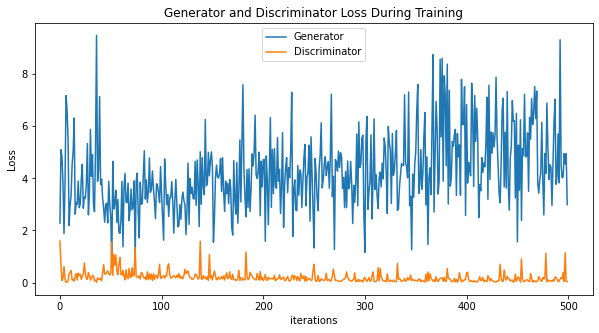

In [ ]:
plt.figure(figsize=(10,5)) #grid size -> show losses
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="Generator")
plt.plot(d_losses,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

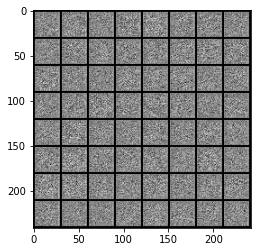

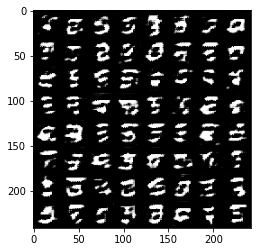

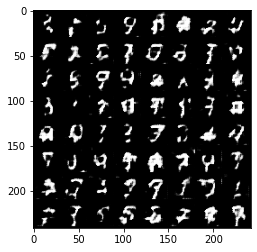

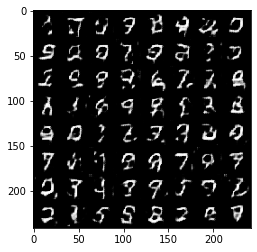

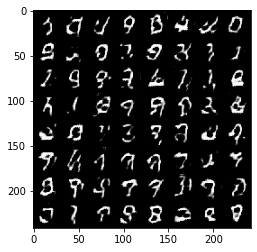

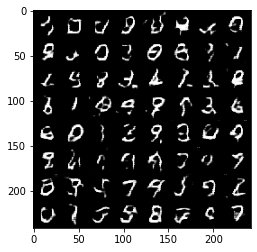

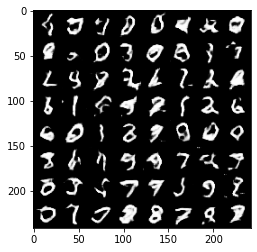

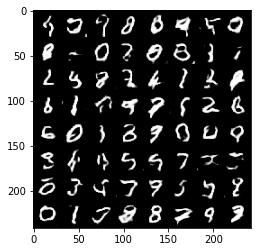

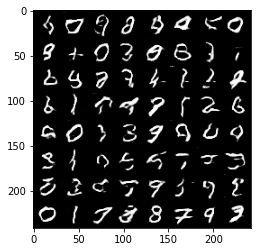

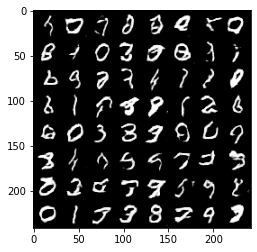

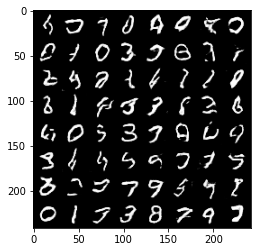

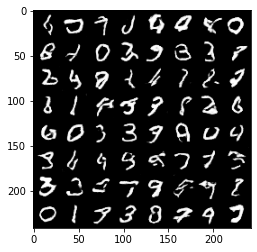

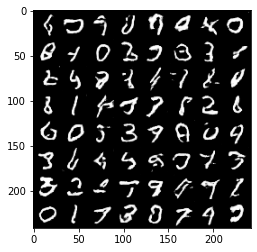

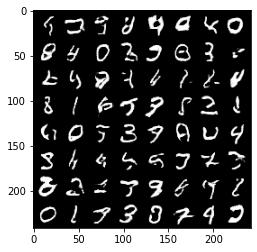

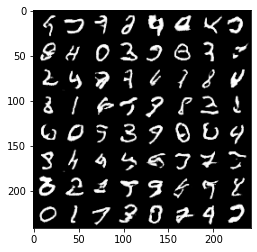

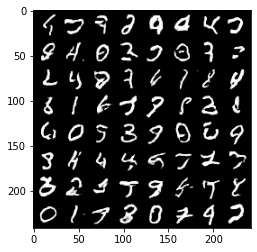

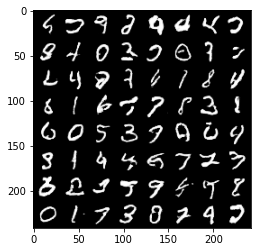

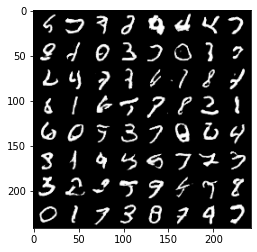

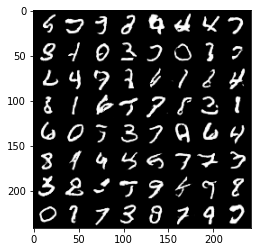

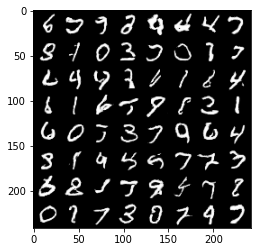

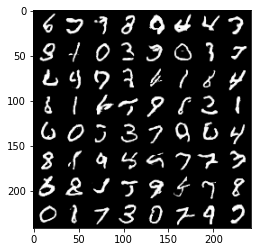

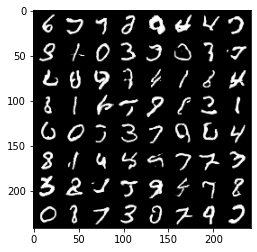

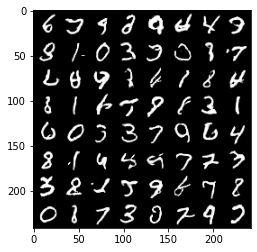

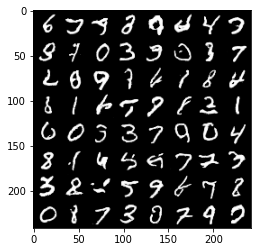

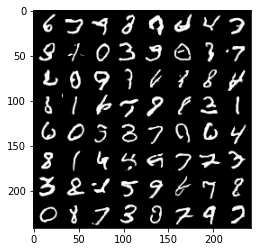

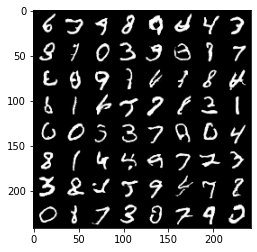

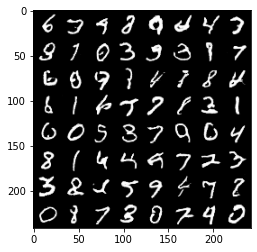

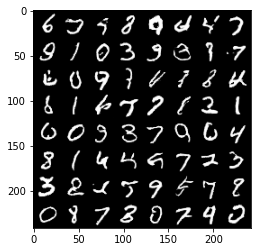

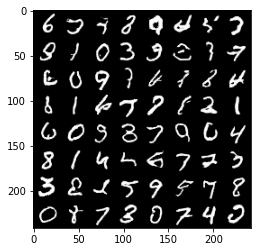

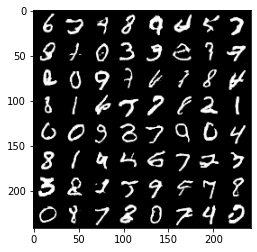

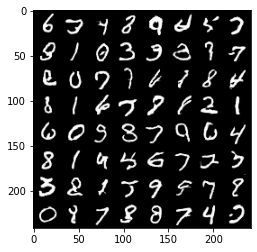

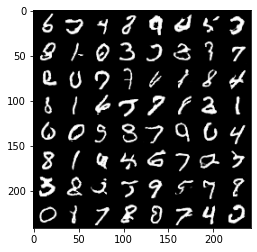

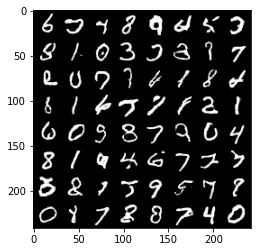

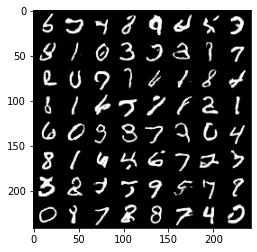

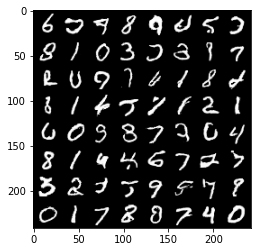

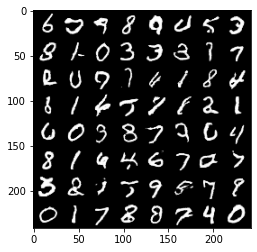

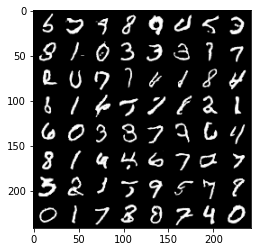

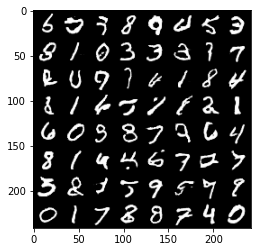

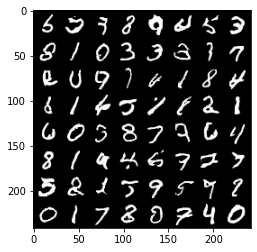

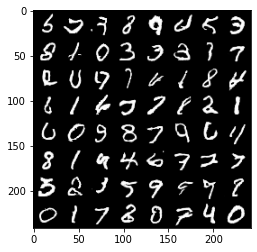

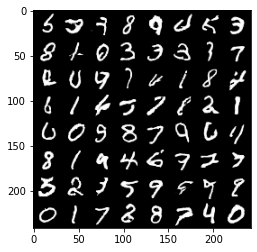

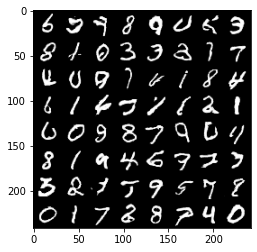

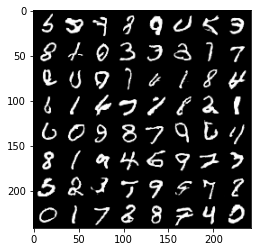

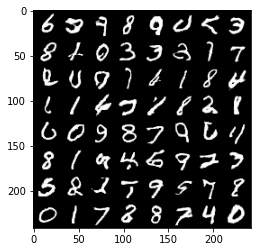

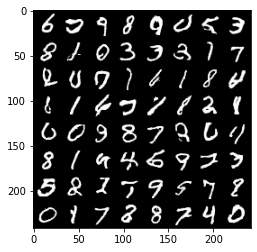

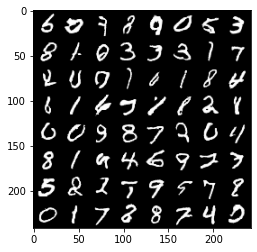

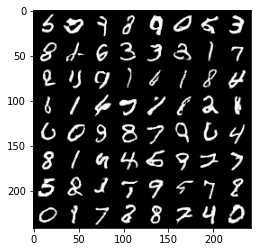

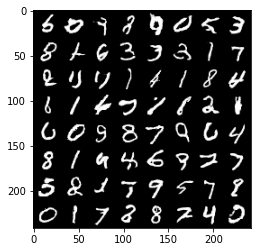

In [ ]:
for image in image_list: #show how training has been going with images
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.show()